In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import numpy as np
#import matplotlib.pyplot as plt
from tqdm import tqdm

#from keras.preprocessing.image import  ImageDataGenerator

from keras.layers import Input, MaxPooling2D, Conv2D, MaxPooling1D, Conv1D
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers


df0 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=3, chunksize=100, usecols=range(1,180) )
df1 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=103, chunksize=100, usecols=range(1,180) )
df2 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=203, chunksize=100,usecols=range(1,180) )
df3 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=303, chunksize=100, usecols=range(1,180) )
df4 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=403, chunksize=100, usecols=range(1,180) )
df5 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=503, chunksize=100, usecols=range(1,180) )
df6 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=603, chunksize=100, usecols=range(1,180) )
df7 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=703, chunksize=100, usecols=range(1,180) )
df8 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=803, chunksize=100, usecols=range(1,180) )
df9 = pd.read_csv('UBIANPFULL.csv',sep=',', header = None, skiprows=903, chunksize=100, usecols=range(1,180) )

random_dim=100

listadf=[df0,df1,df2,df3,df4,df5,df6,df7,df8,df9]

xtreino=[]
for df in listadf:
    k=0
    for chunk in df:
        
        x=np.array(chunk).reshape(17900)
        xtreino.append(x)
        k+=1
        #clear_output()
        #print(k)
        if k == 100:
            break
            
x_train = np.array(xtreino)

def cria_gerador(optimizer):
    
    gerador = Sequential()
    gerador.add(Dense(128, input_dim= random_dim , 
                      kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    gerador.add(LeakyReLU(0.2))
    gerador.add(Dropout(0.05))

    gerador.add(Dense(1024))
    gerador.add(LeakyReLU(0.2))
    gerador.add(Dropout(0.05))

   # gerador.add(Dense(2048))
  #  gerador.add(LeakyReLU(0.2))

   # gerador.add(Dense(4096))
   # gerador.add(LeakyReLU(0.2))
    
    gerador.add(Dense(8192))
    gerador.add(LeakyReLU(0.2))
    gerador.add(Dropout(0.05))
  #  gerador.add(Dense(32768))
   # gerador.add(LeakyReLU(0.2))
    
    gerador.add(Dense(17900, activation='tanh'))
    gerador.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gerador

def cria_discriminador(optimizer):
    
    discriminador = Sequential()
    discriminador.add(Dense(5096, input_dim=17900, 
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminador.add(LeakyReLU(0.2))
    discriminador.add(BatchNormalization())

    #discriminador.add(MaxPooling2D(pool_size=5, strides=None, padding='valid'))
    
    discriminador.add(Dense(2048))
    discriminador.add(LeakyReLU(0.2))
    #discriminador.add(Dropout(0.1))
    discriminador.add(BatchNormalization())


   # discriminador.add(Dense(8192))
   # discriminador.add(LeakyReLU(0.2))
   # discriminador.add(Dropout(0.3))
    
    discriminador.add(Dense(512))
    discriminador.add(LeakyReLU(0.2))
    discriminador.add(BatchNormalization())

    
    #discriminador.add(MaxPooling2D(pool_size=5, strides=None, padding='valid'))
    
   # discriminador.add(Dense(512))
   # discriminador.add(LeakyReLU(0.2))
   # discriminador.add(Dropout(0.3))

    discriminador.add(Dense(1, activation='sigmoid'))
    discriminador.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminador

def cria_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def cria_rede_gan(discriminator, random_dim, generator, optimizer):
    
    # treina-se por ou o discriminador ou o gerador, um por vez
    discriminator.trainable = False
    
    # gan input (ruido) será vetores de 1000 dimensoes;
    gan_input = Input(shape=(random_dim,))
    
    # a saída do gerador
    x = generator(gan_input)
    
    # saída do discriminador, probabilidade da imagem ser real
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 100, 179)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    
def train(epochs=1, batch_size=128):
    
    
    lossdiscr=[]
    lossgan=[]
    
    batch_count = round(x_train.shape[0] / batch_size)
    
    adam = cria_optimizer()
    generador = cria_gerador(adam)
    discriminador = cria_discriminador(adam)
    gan = cria_rede_gan(discriminador, random_dim, generador, adam)
    
    #batch_size , dim = 100, random_dim
    dim = 100
    
    for e in range(1, epochs+1):
        
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        
        for _ in tqdm(range(0,batch_count)):
            
            noise = np.random.normal(0, 1, size=[batch_size, dim])            
            
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            generated_images = generador.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # etiqueta para dados reais e gerados
            y_dis = np.zeros(2*batch_size)
            
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminador.trainable = True
            
            lossdiscrr = discriminador.train_on_batch(X, y_dis) 
            lossdiscr.append(lossdiscrr)
            print(lossdiscrr)
            
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, dim])
            y_gen = np.ones(batch_size)
            discriminador.trainable = False
            
            lossgann = gan.train_on_batch(noise, y_gen) 
            lossgan.append(lossgann)
            

        if  e % 6 == 0:
            plot_generated_images(e, generador)
            
            print(lossdiscrr)
            print(lossgan)
            print("\n  lalalalalalala \n")
            
        #print(lossdiscr)
        #print(lossgan)
    
    ld = pd.DataFrame(lossdiscr)
    lg = pd.DataFrame(lossgan)
    
    ld.to_csv("lossdiscr.csv", sep='\t', index = False)
    lg.to_csv("lossgan.csv", sep='\t',  index = False)
    
train(50, 1000)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

In [10]:
#train(10, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
[1.1482434]



 10%|█         | 1/10 [02:46<25:00, 166.77s/it]

[0.80676746]


KeyboardInterrupt: 

In [ ]:
#train(2, 1)

In [4]:
#x_train.shape[0]

10

In [5]:
#np.shape(x_train)

(10, 17900)

In [6]:
#X

NameError: name 'X' is not defined

In [10]:
#noise = np.random.normal(0, 1, size=[1, 100])

In [11]:
#np.shape(noise)

(1, 100)

In [14]:
#adam = cria_optimizer()
#gerador= cria_gerador(adam)

In [15]:
#gerador

In [17]:
#teste = gerador.predict(noise)

In [19]:
#np.shape(teste)

(1, 17900)

In [21]:
#image_batch = x_train[np.random.randint(0, x_train.shape[0], size=1)]

In [22]:
#np.shape(image_batch)

(1, 17900)

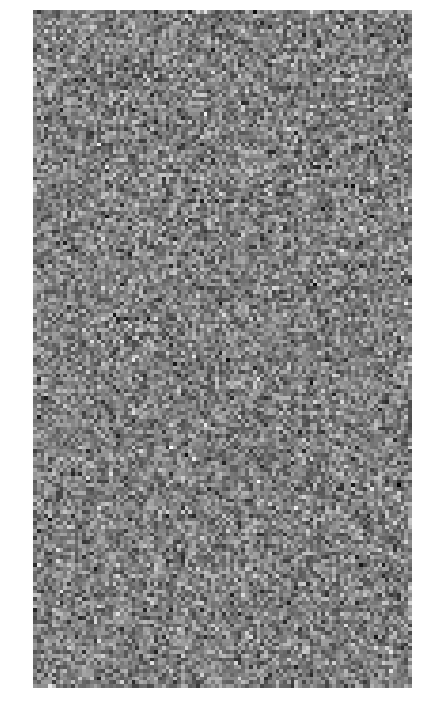

In [27]:
#plot_generated_images(1, gerador, examples=1, dim=(1, 1), figsize=(10, 10))

In [25]:
#def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
#    noise = np.random.normal(0, 1, size=[examples, random_dim])
#    generated_images = generator.predict(noise)
#    generated_images = generated_images.reshape(examples, 179, 100)

#    plt.figure(figsize=figsize)
#    for i in range(generated_images.shape[0]):
#        plt.subplot(dim[0], dim[1], i+1)
#        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
#        plt.axis('off')
#    plt.tight_layout()
#    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [4]:
#from keras.layers.core import Dense, Dropout